In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import seaborn as sns
import pandas as pd
sns.set_theme()

In [2]:
# support functions
def generate_in_distribution_data(n, mu_o):
    X = np.concatenate((1*np.random.randn(int(n/2))+ (mu_o-1), 1*np.random.randn(int(n/2))+ (mu_o+1)))
    y = np.concatenate((np.zeros((int(n/2), )), np.ones(int(n/2), )))
    X, y = shuffle(X, y)
    return X, y

def generate_out_distribution_data(n, mu_ood):
    X = np.concatenate((1*np.random.randn(int(n/2))+ (mu_ood-1), 1*np.random.randn(int(n/2))+ (mu_ood+1)))
    y = np.concatenate((np.zeros((int(n/2), )), np.ones(int(n/2), )))
    X, y = shuffle(X, y)
    return X, y

def compute_decision_rule(X, y):
    n = len(y)
    mu_hat = (1/n)*np.sum(X - (-1)**y)
    return mu_hat

def compute_empirical_risk(X, y, mu_hat):
    y_pred = (X > mu_hat).astype('int')
    risk = 1 - np.mean(y_pred == y)
    return risk

In [30]:
# params
n = 5
n_test = 1000
mu_o = 0
m_sizes = np.arange(0, 21, 1)
reps = 1000

In [31]:
X_test, y_test = generate_in_distribution_data(n_test, mu_o)

df = pd.DataFrame()
Delta = [0, 0.1, 0.2, 0.5, 0.6, 0.7, 0.8, 1, 1.5, 2]

i = 0
for m in m_sizes:
    X, y = generate_in_distribution_data(n, mu_o)
    for r, rep in enumerate(range(reps)):
        df.at[i, "m"] = m
        df.at[i, "r"] = r
        
        for delta in Delta:
            X_ood, y_ood = generate_out_distribution_data(m, delta)
            X_comb = np.concatenate((X, X_ood))
            y_comb = np.concatenate((y, y_ood))
            X_comb, y_comb = shuffle(X_comb, y_comb)
            mu_hat = compute_decision_rule(X_comb, y_comb)
            df.at[i, str(delta)] = compute_empirical_risk(X_test, y_test, mu_hat)
        i+=1

In [32]:
df["m"] = df["m"]/n

In [33]:
dfm = df.melt(['m', 'r'], var_name='Delta', value_name='Risk')

(0.0, 4.0)

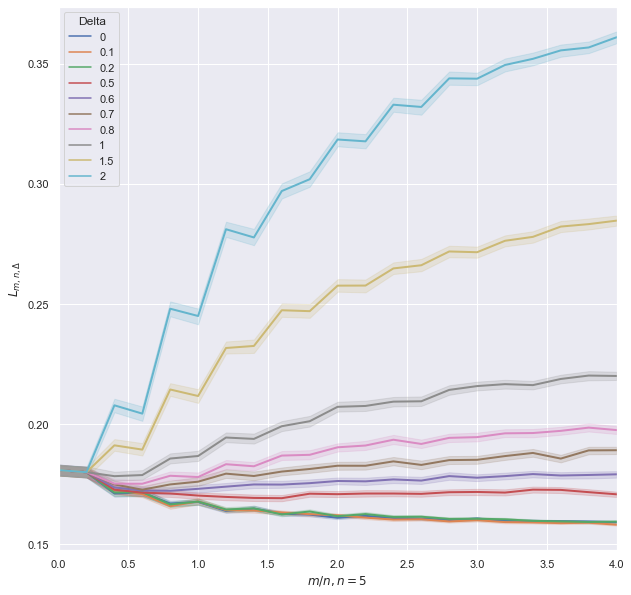

In [34]:
fig1, ax = plt.subplots(figsize=(10, 10), facecolor='white')
ax = sns.lineplot(data=dfm, x="m", y="Risk", hue="Delta", ax=ax, markers=True, ci=95, lw=2)
ax.set_ylabel(r"$L_{m, n, \Delta}$")
ax.set_xlabel(r"$m/n, n=5$")
ax.set_xlim([0, 4])
# ax.set_xticklabels(m_sizes/n)

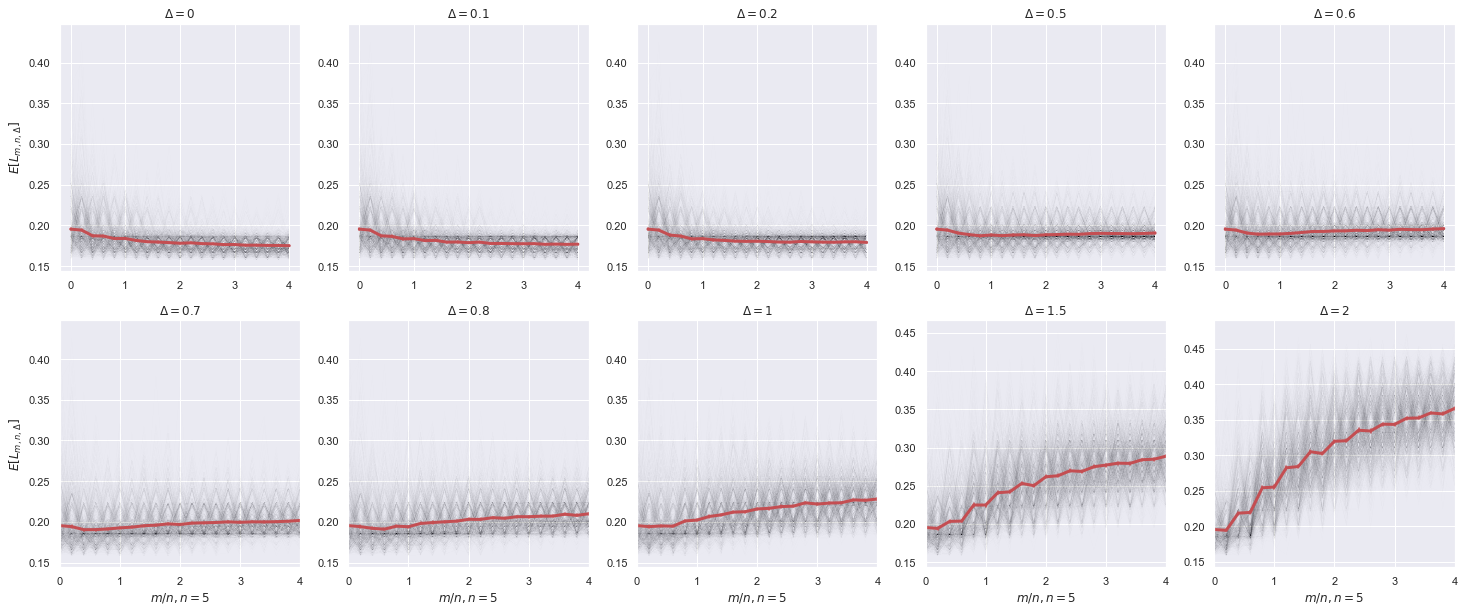

In [530]:
fig2, axs = plt.subplots(2, 5, figsize=(25, 10), facecolor='white')
axs = axs.ravel()
for i, delta in enumerate(Delta):
    ax = sns.lineplot(data=df, x="m", y=str(delta), hue="r", palette=sns.color_palette(['black'], len(df["r"].unique())), ax=axs[i], estimator=None, lw=0.2, alpha=0.01, legend=False)
    ax = sns.lineplot(data=df, x="m", y=str(delta), ax=ax, markers=True, color='r', err_style="bars", lw=3)
    ax.set_title(r"$\Delta = {}$".format(str(delta)))
    ax.set_xlabel("")
    ax.set_ylabel("")
    if i == 0 or i == 5:
        ax.set_ylabel(r"$L_{m, n, \Delta}$")
    if i in np.arange(5, 10, 1):
        ax.set_xlabel(r"$m/n, n=5$")
        ax.set_xlim([0, 4])

In [519]:
# save plots
fig1.savefig("simple_ood_exp_sim_plot.png")
fig2.savefig("simple_ood_exp_sim_rep_plot.png")

In [531]:
# save results
df.to_csv("gaussian_task_results.csv")